Exploring GPU efficiency properties following [cHHillee](https://twitter.com/cHHillee/status/1630274804795445248) and similar sources.

In [1]:
!nvidia-smi

Thu Aug 17 21:11:36 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-80GB           On | 00000000:07:00.0 Off |                  Off |
| N/A   33C    P0               70W / 400W|  67928MiB / 81920MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [2]:
%%capture
! pip install seaborn

In [3]:
import torch
import time
import seaborn as sns
import pandas as pd
import tqdm
import re
sns.set_theme(style="darkgrid")
sns.set(rc={"figure.figsize":(10, 10)})

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Create simple benchmarking code for $m\times k$ by $k \times n$ matrix-multiplies, batched.

In [4]:
def benchmark(results, batch_size, m, k, n, warmups=3, num_iters=10):
    assert warmups > 0, "Use at least one warmup"
    with torch.inference_mode():
        T = torch.randn(batch_size, m, k, device="cuda", dtype=torch.float16)
        W = torch.randn(k, n, device="cuda", dtype=torch.float16)
        # Profile to get the kernel name
        with torch.profiler.profile() as prof:
            T @ W
        matmul_event = [e for e in prof.events() if "gemm" in e.name or "triton" in e.name or "gemv" in e.name]
        kernel = matmul_event[0].name if len(matmul_event) == 1 else "more than one kernel"

        for _ in range(warmups):
            T @ W
            
        times_in_sec = []
        for _ in range(num_iters):
            torch.cuda.synchronize()
            start = torch.cuda.Event(enable_timing=True)
            stop = torch.cuda.Event(enable_timing=True)
            start.record()
            T @ W
            stop.record()
            torch.cuda.synchronize()

            # CUDA timings are in ms:
            times_in_sec.append(start.elapsed_time(stop) / 1e3)
        time = sum(times_in_sec) / len(times_in_sec)
        FLOPs = (2 * k - 1) * batch_size * m * n
        mem_in_bytes = T.element_size() * T.numel() + W.element_size() * W.numel()
        del T
        del W
        results.append({"time": time,
                        "kernel": kernel,
                        "batch_size": batch_size,
                        "m": m,
                        "k": k,
                        "n": n,
                        "avg_mem_bandwidth": 2 * mem_in_bytes / time,
                        "comp_intensity": FLOPs / (2 * mem_in_bytes), 
                        "TFLOPs": FLOPs / 2 ** 40,
                        "TFLOP/s": FLOPs / time / 2 ** 40})
        


# Computational Intensity

Start with the simple `batch_size = 1` and `m = k = n` case.  The A100(80GB) math-intensity ratio is ~150 FLOPs/B, theoretically, so we should expect that when the computational intensity crosses this scale we get better gpu utilization.

In [5]:
bsz_1_mkn_equal_results = []
for exp in tqdm.tqdm(range(2, 16)):
    benchmark(bsz_1_mkn_equal_results, batch_size=1, m=2**exp, k=2**exp, n=2**exp)

100%|██████████| 14/14 [00:16<00:00,  1.21s/it]


In [6]:

bsz_1_mkn_equal_results_df = pd.DataFrame(bsz_1_mkn_equal_results)
bsz_1_mkn_equal_results_df

,time,kernel,batch_size,m,k,n,avg_mem_bandwidth,comp_intensity,TFLOPs,TFLOP/s
0,0.000048,void cutlass::Kernel<cutlass_80_wmma_tensorop_...,1,4,4,4,2.692152e+06,0.875,1.018634e-10,0.000002
1,0.000035,void cutlass::Kernel<cutlass_80_wmma_tensorop_...,1,8,8,8,1.445870e+07,1.875,8.731149e-10,0.000025
2,0.000035,void cutlass::Kernel<cutlass_80_wmma_tensorop_...,1,16,16,16,5.797627e+07,3.875,7.217750e-09,0.000204
3,0.000036,void cutlass::Kernel<cutlass_80_wmma_tensorop_...,1,32,32,32,2.254315e+08,7.875,5.867332e-08,0.001615
4,0.000036,void cutlass::Kernel<cutlass_80_wmma_tensorop_...,1,64,64,64,8.988764e+08,15.875,4.731119e-07,0.012978
5,0.000052,sm80_xmma_gemm_f16f16_f16f32_f32_nn_n_tilesize...,1,128,128,128,2.544890e+09,31.875,3.799796e-06,0.073777
6,0.000070,sm80_xmma_gemm_f16f16_f16f32_f32_nn_n_tilesize...,1,256,256,256,7.498741e+09,63.875,3.045797e-05,0.435632
7,0.000042,ampere_fp16_s16816gemm_fp16_64x64_ldg8_f2f_sta...,1,512,512,512,5.008100e+10,127.875,2.439022e-04,5.824502
8,0.000069,sm80_xmma_gemm_f16f16_f16f32_f32_nn_n_tilesize...,1,1024,1024,1024,1.223657e+11,255.875,1.952171e-03,28.476569
9,0.000122,ampere_fp16_s16816gemm_fp16_128x128_ldg8_f2f_s...,1,2048,2048,2048,2.745538e+11,511.875,1.562119e-02,127.817878


We expect a jump in the TFLOP/s when the computational intensity crosses the $\sim 10 ^ {2}$ range

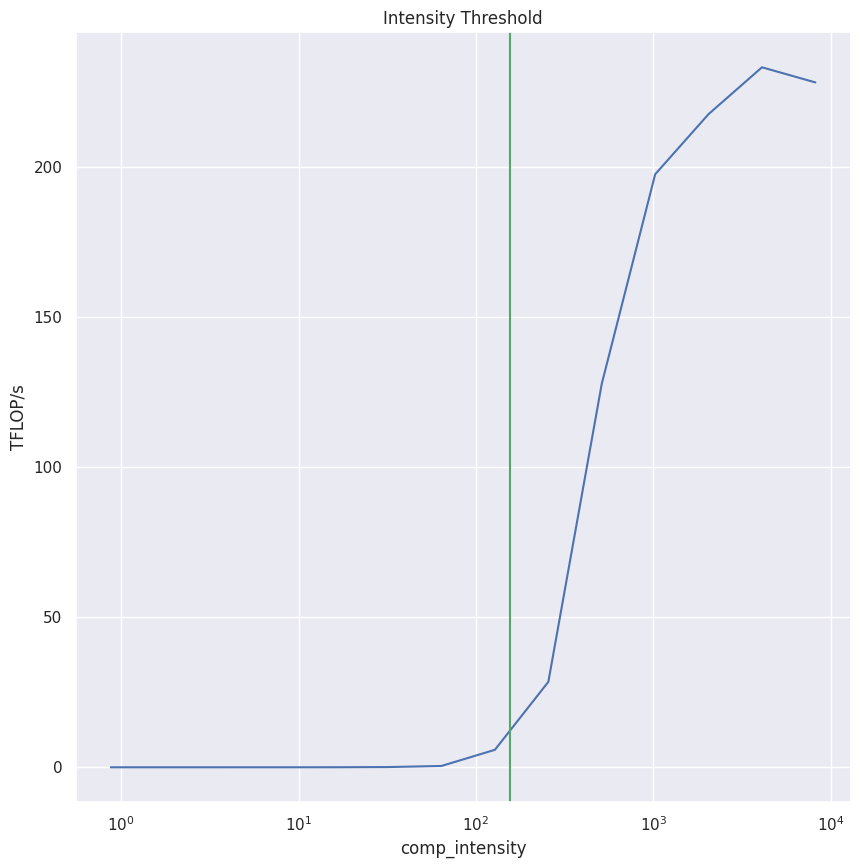

In [50]:
plot = sns.lineplot(x="comp_intensity", y="TFLOP/s", data=bsz_1_mkn_equal_results_df)
plot.set(xscale="log")
plot.set(title="Intensity Threshold")
plot.axvline(156, color="g") # Theoretical A100 80GiB math intensity

What if we vary the batch size as well?

In [8]:
mkn_equal_results = []
for bsz_exp in tqdm.tqdm(range(9)):
    for dim_exp in range(2, 14):
        benchmark(mkn_equal_results,
                  batch_size=2**bsz_exp,
                  m=2**dim_exp,
                  k=2**dim_exp,
                  n=2**dim_exp)
        

100%|██████████| 9/9 [00:39<00:00,  4.42s/it]


In [9]:
mkn_equal_results_df = pd.DataFrame(mkn_equal_results)
mkn_equal_results_df

,time,kernel,batch_size,m,k,n,avg_mem_bandwidth,comp_intensity,TFLOPs,TFLOP/s
0,0.000046,void cutlass::Kernel<cutlass_80_wmma_tensorop_...,1,4,4,4,2.796421e+06,0.875000,1.018634e-10,0.000002
1,0.000055,void cutlass::Kernel<cutlass_80_wmma_tensorop_...,1,8,8,8,9.316951e+06,1.875000,8.731149e-10,0.000016
2,0.000036,void cutlass::Kernel<cutlass_80_wmma_tensorop_...,1,16,16,16,5.647225e+07,3.875000,7.217750e-09,0.000199
3,0.000039,void cutlass::Kernel<cutlass_80_wmma_tensorop_...,1,32,32,32,2.107169e+08,7.875000,5.867332e-08,0.001509
4,0.000036,void cutlass::Kernel<cutlass_80_wmma_tensorop_...,1,64,64,64,8.985609e+08,15.875000,4.731119e-07,0.012974
...,...,...,...,...,...,...,...,...,...,...
103,0.000345,ampere_fp16_s16816gemm_fp16_128x128_ldg8_f2f_s...,256,512,512,512,7.803061e+11,254.754864,6.243896e-02,180.795527
104,0.002268,ampere_fp16_s16816gemm_fp16_128x128_ldg8_f2f_s...,256,1024,1024,1024,4.752691e+11,509.758755,4.997559e-01,220.345624
105,0.019675,ampere_fp16_s16816gemm_fp16_128x128_ldg8_f2f_s...,256,2048,2048,2048,2.191461e+11,1019.766537,3.999023e+00,203.251920
106,0.144769,more than one kernel,256,4096,4096,4096,1.191347e+11,2039.782101,3.199609e+01,221.015255


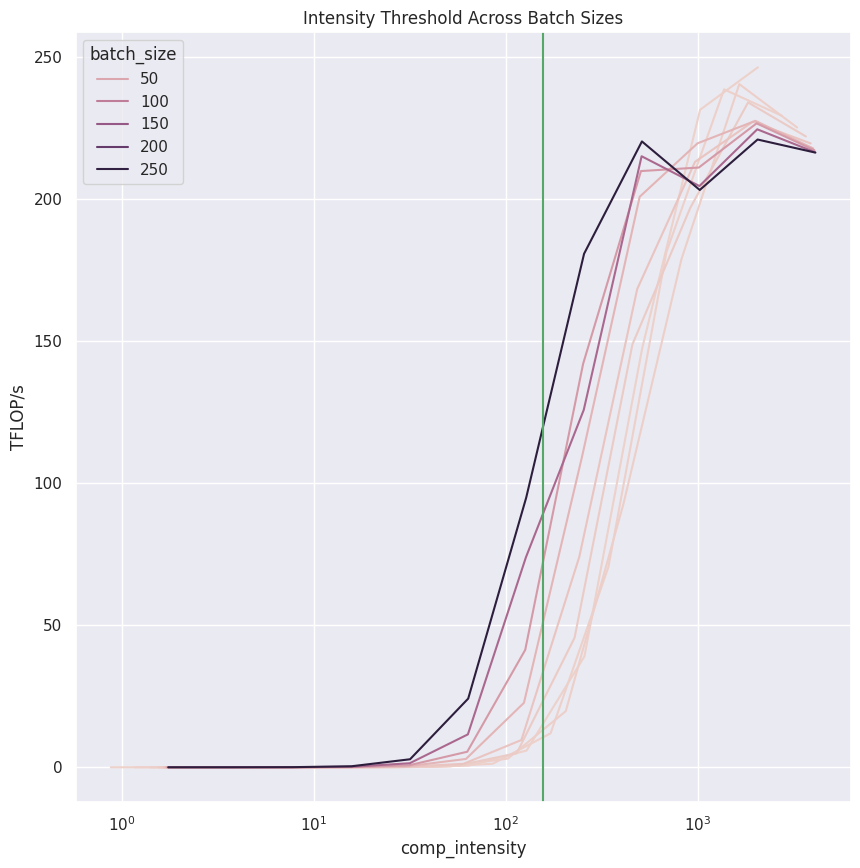

In [10]:
plot = sns.lineplot(x="comp_intensity",
                    y="TFLOP/s",
                    data=mkn_equal_results_df,
                    hue="batch_size")
plot.set(title="Intensity Threshold Across Batch Sizes")
plot.set(xscale="log")
plot.axvline(156, color="g") # Theoretical A100 80GiB math intensity

In [11]:
plot.figure.savefig("flops_vs_intensity.png", dpi=256)


The efficiency divide is still at an intensity around ~100, but it is clear that larger batches hit the efficiency threshold sooner.

# Tensor Dimension

Let us do a more fine-grained search over tensor dimension size:

In [12]:
square_matmul_results = []
for dim in tqdm.tqdm(range(1, 2 ** 12 + 1)):
    benchmark(square_matmul_results,
              batch_size=1,
              m=dim,
              k=dim,
              n=dim)

100%|██████████| 4096/4096 [00:29<00:00, 141.04it/s]


In [13]:
square_matmul_results_df = pd.DataFrame(square_matmul_results)
square_matmul_results_df

,time,kernel,batch_size,m,k,n,avg_mem_bandwidth,comp_intensity,TFLOPs,TFLOP/s
0,0.000036,"std::enable_if<!(false), void>::type internal:...",1,1,1,1,2.227965e+05,0.125,9.094947e-13,2.532903e-08
1,0.000064,void cutlass::Kernel<cutlass_80_wmma_tensorop_...,1,2,2,2,4.996253e+05,0.375,1.091394e-11,1.704025e-07
2,0.000045,void cutlass::Kernel<cutlass_75_wmma_tensorop_...,1,3,3,3,1.592244e+06,0.625,4.092726e-11,9.050859e-07
3,0.000043,void cutlass::Kernel<cutlass_80_wmma_tensorop_...,1,4,4,4,2.948983e+06,0.875,1.018634e-10,2.346824e-06
4,0.000045,void cutlass::Kernel<cutlass_75_wmma_tensorop_...,1,5,5,5,4.412284e+06,1.125,2.046363e-10,4.514567e-06
...,...,...,...,...,...,...,...,...,...,...
4091,0.000918,void cutlass::Kernel<cutlass_80_tensorop_f16_s...,1,4092,4092,4092,1.459319e+11,1022.875,1.246189e-01,1.357604e+02
4092,0.001681,void cutlass::Kernel<cutlass_75_tensorop_f16_s...,1,4093,4093,4093,7.972926e+10,1023.125,1.247103e-01,7.419021e+01
4093,0.000918,void cutlass::Kernel<cutlass_80_tensorop_f16_s...,1,4094,4094,4094,1.460217e+11,1023.375,1.248017e-01,1.359103e+02
4094,0.001653,void cutlass::Kernel<cutlass_75_tensorop_f16_s...,1,4095,4095,4095,8.117590e+10,1023.625,1.248932e-01,7.557326e+01


[Text(0.5, 0, 'm=k=n')]

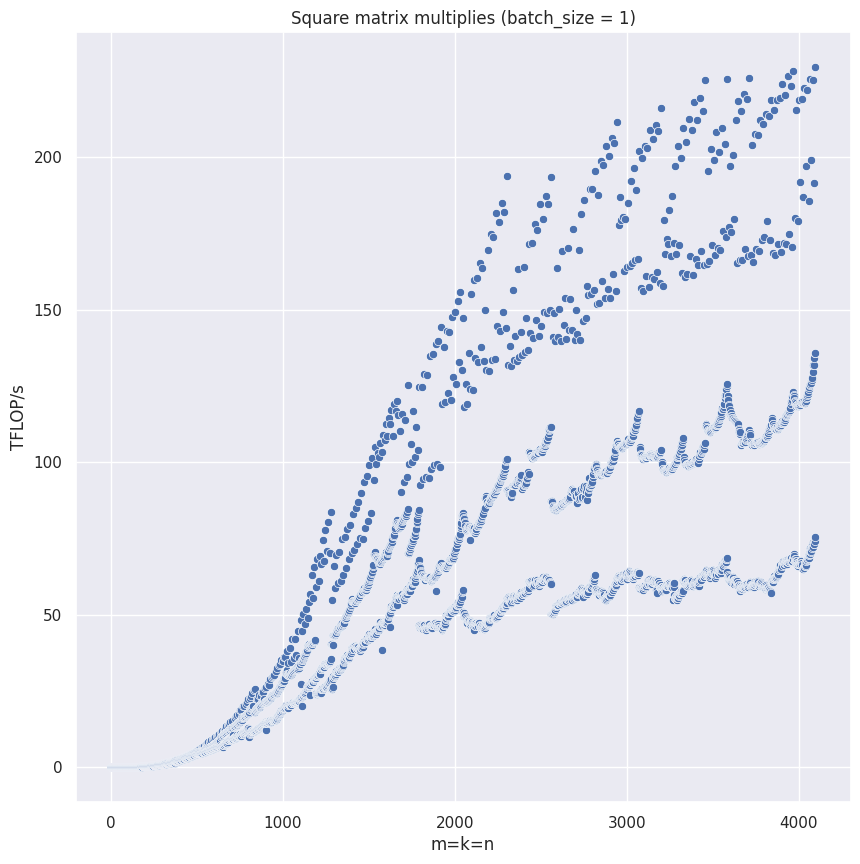

In [14]:
plot = sns.scatterplot(x="m",
                       y="TFLOP/s",
                       data=square_matmul_results_df
                      )
plot.set(title="Square matrix multiplies (batch_size = 1)")
plot.set(xlabel="m=k=n")

Something structured is going on!  Beyond the general up-and-to-the-right trend, which is just a reflection of comptuational intensity benefits.


Let us color code by the largest power-of-two that the matrix dimensions are divisible by, $2^n$ up to some max $n$

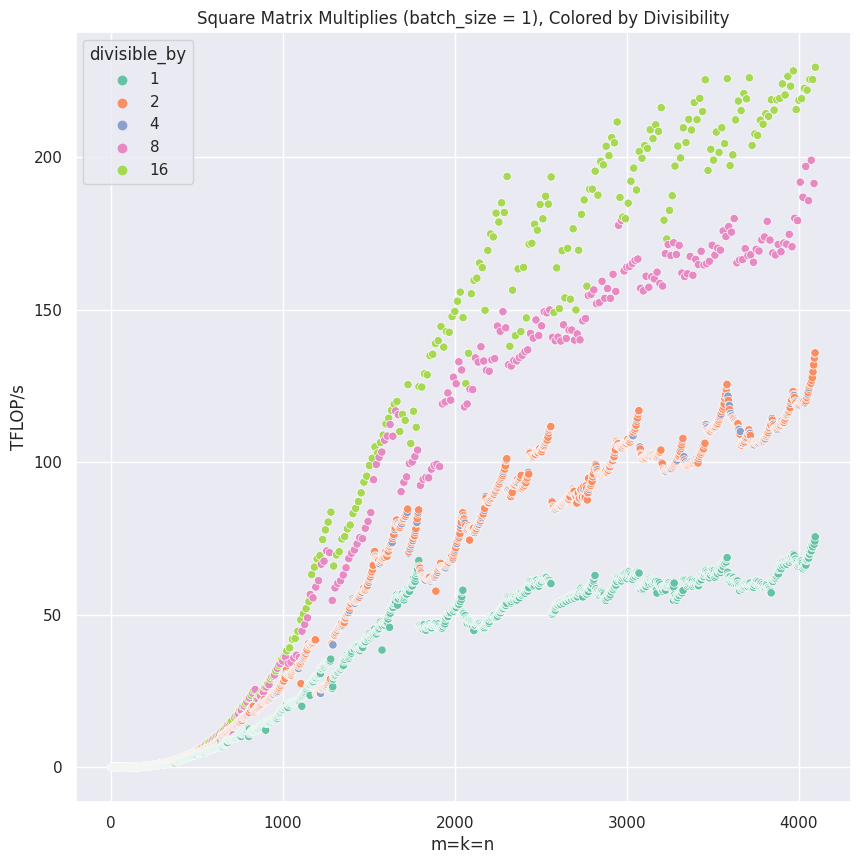

In [15]:
def code_by_divisibility(x, max_exp=4):
    for exp in reversed(range(max_exp + 1)):
        factor = 2 ** exp
        num_elements = x.k
        if not num_elements % factor:
            return factor
        
square_matmul_results_df["divisible_by"] = square_matmul_results_df.apply(code_by_divisibility, axis=1)

plot = sns.scatterplot(x="m",
                       y="TFLOP/s",
                       data=square_matmul_results_df,
                       hue="divisible_by",
                       palette="Set2"
                      )
plot.set(title="Square Matrix Multiplies (batch_size = 1), Colored by Divisibility")
plot.set(xlabel="m=k=n")
plot.figure.savefig("flops_vs_dim_divisibility.png", dpi=256)

We see ~4 gross trends which reflect what power of 2 the dimension are divisible by (increase `max_exp` above to verify that no futher obvious trends emerge).  These trends appear to be due to the alignment properties between the data size and cache-line; more below.


Alternatively, we can color by CUDA kernel. Some of the kernel choices are clearly correlated with power-of-two divisibility, but it also determines some of the smaller-scale trends:

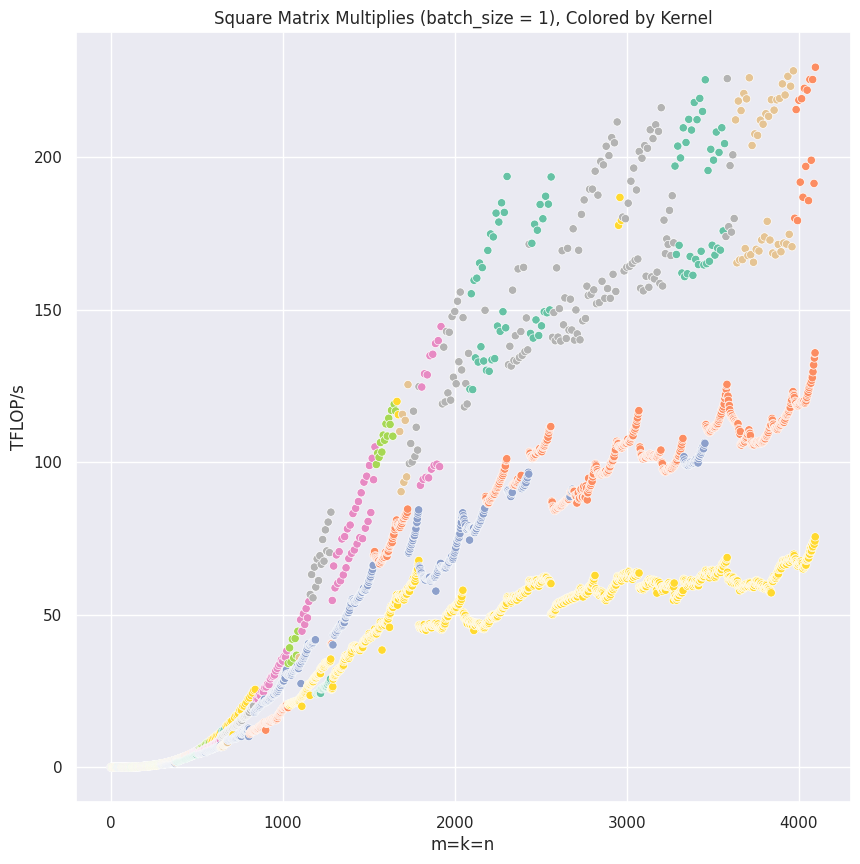

In [16]:
plot = sns.scatterplot(x="m",
                    y="TFLOP/s",
                    data=square_matmul_results_df,
                    hue="kernel", 
                    palette="Set2",
                    legend=False
                   )
plot.set(title="Square Matrix Multiplies (batch_size = 1), Colored by Kernel")
plot.set(xlabel="m=k=n")
plot.figure.savefig("flops_vs_dim_kernel.png", dpi=256)

There are three primary GPU architecture properties we should consider to further understand these plots:

- **Tile Quantization**: matmuls are computed through tiling, in which the full matrices are broken into $t_x\times t_y$-shaped sub-matrices which get multiplied together.  Any partially-fitting tiles are padded by trivial zeros ([which still need to get multiplied out](https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc)), and so we want to avoid such ill-fitting shapes.  Correspondingly, we expect to see drops in efficiency whenever such tile-thresholds are crossed: this is tile quantization. (cuBLAS will sometimes try to minimize tile quantization by switching to smaller-tile kernels, but such kernels are also less efficient, making this a trade-off).
- **Memory Alignment**: The preceding $t_x\times t_y$-shaped tiles need to be read in from physical memory and it important for these reads to be minimized. The amount of data that is read in at a time is determined by the _cache line_ size, which seems to be 128 bytes.
- **Wave Quantization**: GPUs have a number of cores ("streaming multi-processors" or SMs) which act in parallel, 108 in the case of the A100 GiB.  All of the SMs act in parallel, so whether 109 or 216 kernels need to be evaluated, two waves will be launched. Correspondingly, we expect to see drops in efficiency whenever such wave-thresholds are crossed: this is wave quantization.

Scrape the kernel names to find the tile shapes and then compute the number of tiles in each dimension are needed, along with the number of waves and a boolean for whether the tile dimensions perfectly align with the matrix dimensions.

In [17]:
def get_tile_tuple(kernel_str):
    """
    Scrapes the kernel name to try and get the tile size
    """
    result = re.search(r"(\d+)x(\d+)", kernel_str)
    if result is None:
        return (None, None)
    tile_x, tile_y = result.groups()[:2]
    return int(tile_x), int(tile_y)

def div_round_up(num, divisor):
    div, mod = divmod(int(num), int(divisor))
    return div + int(bool(mod))

Remove the few cases whose tile size could not be scraped for simplicity (can check that there is only one case)

In [18]:

square_matmul_results_df["tile_x_size"] = square_matmul_results_df.kernel.apply(lambda x: get_tile_tuple(x)[0])
square_matmul_results_df["tile_y_size"] = square_matmul_results_df.kernel.apply(lambda x: get_tile_tuple(x)[1])
square_matmul_results_filtered_df = square_matmul_results_df.copy()[square_matmul_results_df.tile_x_size.notna()]


In [19]:

square_matmul_results_filtered_df["num_y_tiles"] = square_matmul_results_filtered_df.apply(lambda x: div_round_up(x.m, x.tile_y_size), axis=1)
square_matmul_results_filtered_df["num_x_tiles"] = square_matmul_results_filtered_df.apply(lambda x: div_round_up(x.m, x.tile_x_size), axis=1)
square_matmul_results_filtered_df["num_tiles"] = square_matmul_results_filtered_df.num_x_tiles * square_matmul_results_filtered_df.num_y_tiles 
square_matmul_results_filtered_df["waves"] = square_matmul_results_filtered_df.num_tiles.apply(lambda x: div_round_up(x, 108))
square_matmul_results_filtered_df["aligned_waves"] = square_matmul_results_filtered_df.num_tiles % 108 == 0
square_matmul_results_filtered_df["aligned_tiles"] = (square_matmul_results_filtered_df.m % square_matmul_results_filtered_df.tile_x_size == 0) & (square_matmul_results_filtered_df.m % square_matmul_results_filtered_df.tile_y_size == 0)
square_matmul_results_filtered_df["excess_tile_usage"] = ((square_matmul_results_filtered_df.tile_x_size - square_matmul_results_filtered_df.m) % square_matmul_results_filtered_df.tile_x_size) * ((square_matmul_results_filtered_df.tile_y_size - square_matmul_results_filtered_df.m) % square_matmul_results_filtered_df.tile_y_size)
square_matmul_results_filtered_df["excess_wave_usage"] = (108 - square_matmul_results_filtered_df.num_tiles) % 108

                                                      

### Tiles

Many top-peaks correspond to perfect tile-alignment:

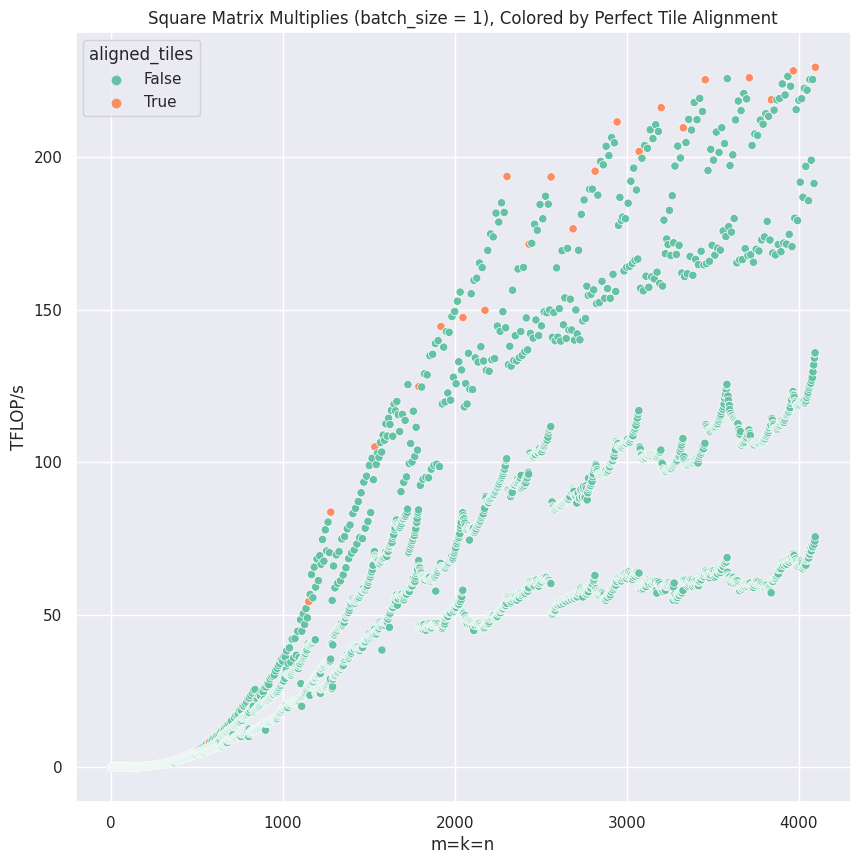

In [20]:
plot = sns.scatterplot(x="m",
                       y="TFLOP/s",
                       data=square_matmul_results_filtered_df,
                       hue="aligned_tiles", 
                       palette="Set2"
                      )
plot.set(title="Square Matrix Multiplies (batch_size = 1), Colored by Perfect Tile Alignment")
plot.set(xlabel="m=k=n")
plot.figure.savefig("flops_vs_dim_tile_alignment.png", dpi=256)

A more granular plot of excess tile coverage shows the trend in a bit more detail:

[Text(0.5, 0, 'm=k=n')]

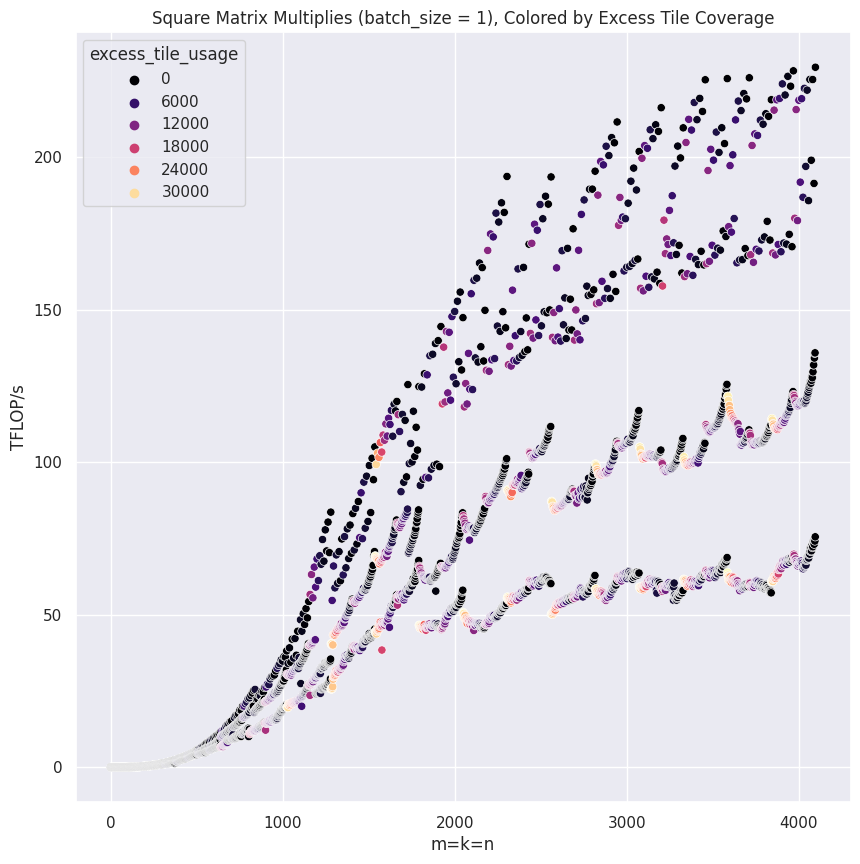

In [21]:
plot = sns.scatterplot(x="m",
                       y="TFLOP/s",
                       data=square_matmul_results_filtered_df,
                       hue="excess_tile_usage", 
                       palette="magma"
                      )
plot.set(title="Square Matrix Multiplies (batch_size = 1), Colored by Excess Tile Coverage")
plot.set(xlabel="m=k=n")

### Waves

Next: waves. Sudden drops in neighboring curves often (but not always) correspond to wave thresholds.

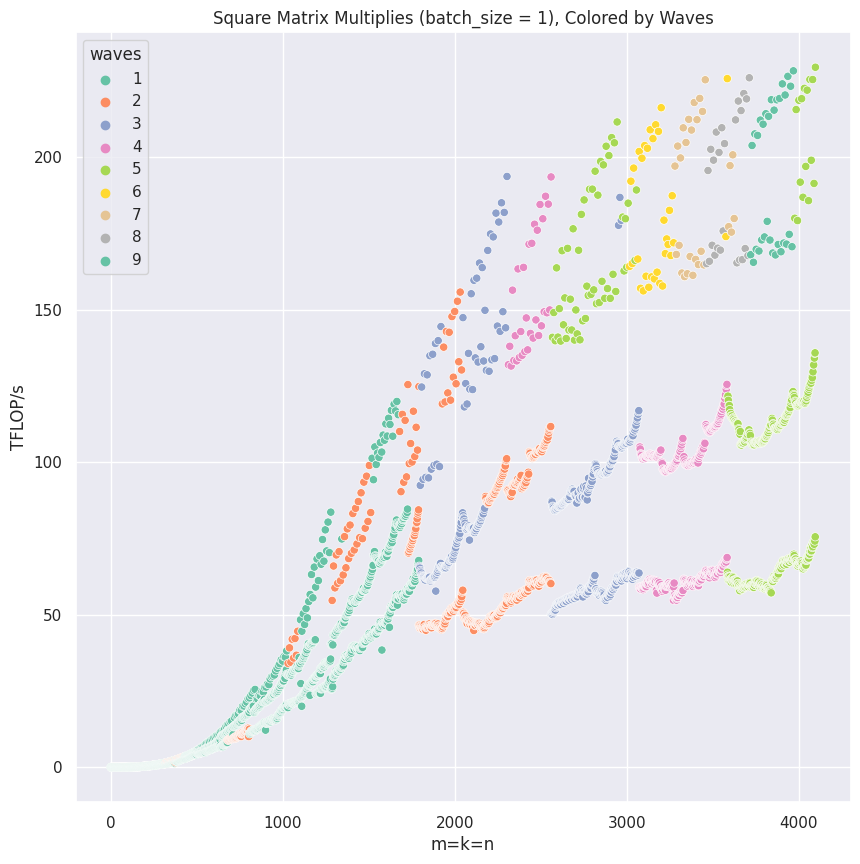

In [22]:
plot = sns.scatterplot(x="m",
                       y="TFLOP/s",
                       data=square_matmul_results_filtered_df,
                       hue="waves", 
                       palette="Set2"
                      )
plot.set(title="Square Matrix Multiplies (batch_size = 1), Colored by Waves")
plot.set(xlabel="m=k=n")
plot.figure.savefig("flops_vs_dim_waves.png", dpi=256)

And by excess wave usage:

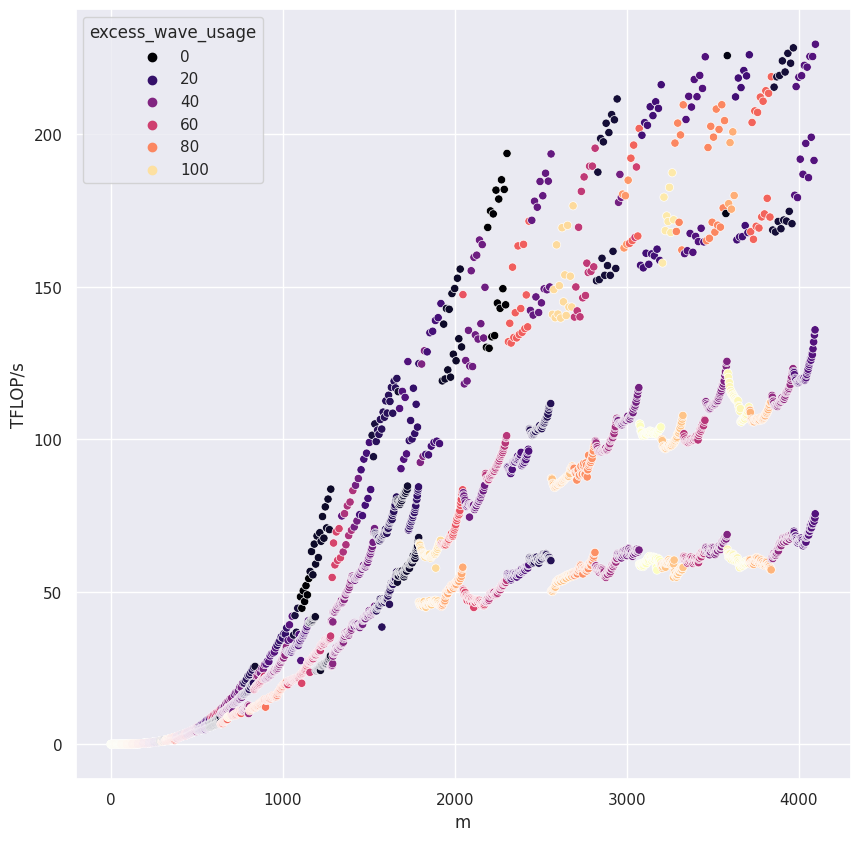

In [23]:
plot = sns.scatterplot(x="m",
                       y="TFLOP/s",
                       data=square_matmul_results_filtered_df,
                       hue="excess_wave_usage", 
                       palette="magma"
                      )

### Top Sizes

Zoom in on the top-performing sizes

In [24]:

square_matmul_results_filtered_top_df = square_matmul_results_filtered_df.sort_values("TFLOP/s", ascending=False).copy()[:10]
square_matmul_results_filtered_top_df

,time,kernel,batch_size,m,k,n,avg_mem_bandwidth,comp_intensity,TFLOPs,TFLOP/s,...,tile_x_size,tile_y_size,num_y_tiles,num_x_tiles,num_tiles,waves,aligned_waves,aligned_tiles,excess_tile_usage,excess_wave_usage
4095,0.000544,void cutlass::Kernel<cutlass_80_tensorop_f16_s...,1,4096,4096,4096,2.465280e+11,1023.875,0.124985,229.569057,...,128.0,256.0,16,32,512,5,False,True,0.0,28
3967,0.000498,void cutlass::Kernel<cutlass_80_tensorop_f16_s...,1,3968,3968,3968,2.531794e+11,991.875,0.113629,228.394413,...,128.0,128.0,31,31,961,9,False,True,0.0,11
3935,0.000489,void cutlass::Kernel<cutlass_80_tensorop_f16_s...,1,3936,3936,3936,2.532282e+11,983.875,0.110902,226.595963,...,128.0,128.0,31,31,961,9,False,False,1024.0,11
3711,0.000411,void cutlass::Kernel<cutlass_80_tensorop_f16_s...,1,3712,3712,3712,2.679436e+11,927.875,0.093024,226.116872,...,128.0,128.0,29,29,841,8,False,True,0.0,23
3583,0.000371,sm80_xmma_gemm_f16f16_f16f32_f32_nn_n_tilesize...,1,3584,3584,3584,2.771748e+11,895.875,0.083729,225.840235,...,160.0,128.0,28,23,644,6,False,False,0.0,4
4063,0.000541,void cutlass::Kernel<cutlass_80_tensorop_f16_s...,1,4064,4064,4064,2.441303e+11,1015.875,0.122078,225.559994,...,128.0,256.0,16,32,512,5,False,False,1024.0,28
4079,0.000548,void cutlass::Kernel<cutlass_80_tensorop_f16_s...,1,4080,4080,4080,2.431494e+11,1019.875,0.123526,225.538349,...,128.0,256.0,16,32,512,5,False,False,256.0,28
3455,0.000333,void cutlass::Kernel<cutlass_80_tensorop_f16_s...,1,3456,3456,3456,2.869593e+11,863.875,0.075074,225.461002,...,128.0,128.0,27,27,729,7,False,True,0.0,27
3903,0.000483,void cutlass::Kernel<cutlass_80_tensorop_f16_s...,1,3904,3904,3904,2.525086e+11,975.875,0.108219,224.114788,...,128.0,128.0,31,31,961,9,False,False,4096.0,11
3951,0.000503,void cutlass::Kernel<cutlass_80_tensorop_f16_s...,1,3952,3952,3952,2.485851e+11,987.875,0.112260,223.345535,...,128.0,128.0,31,31,961,9,False,False,256.0,11


[Text(0.5, 0, 'm=k=n')]

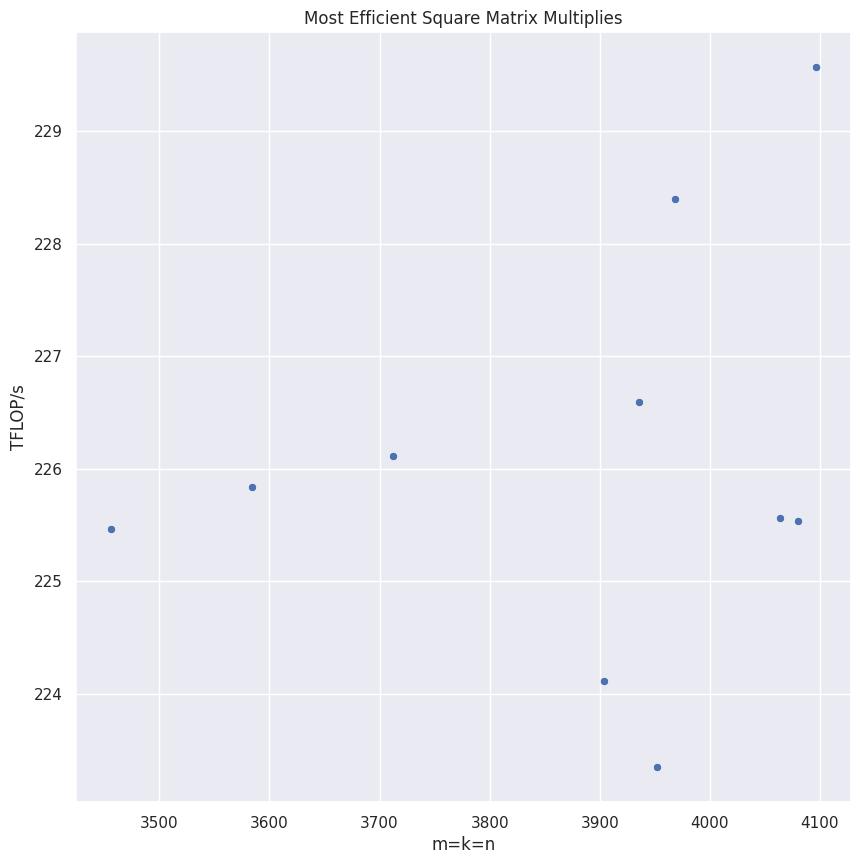

In [25]:
plot = sns.scatterplot(x="m",
                       y="TFLOP/s",
                       data=square_matmul_results_filtered_top_df
                      )
plot.set(title=f"Most Efficient Square Matrix Multiplies")
plot.set(xlabel="m=k=n")


What separates the top-performers?

Tile-alignment seems to be important, but not true for one of the top data points.

[Text(0.5, 0, 'm=k=n')]

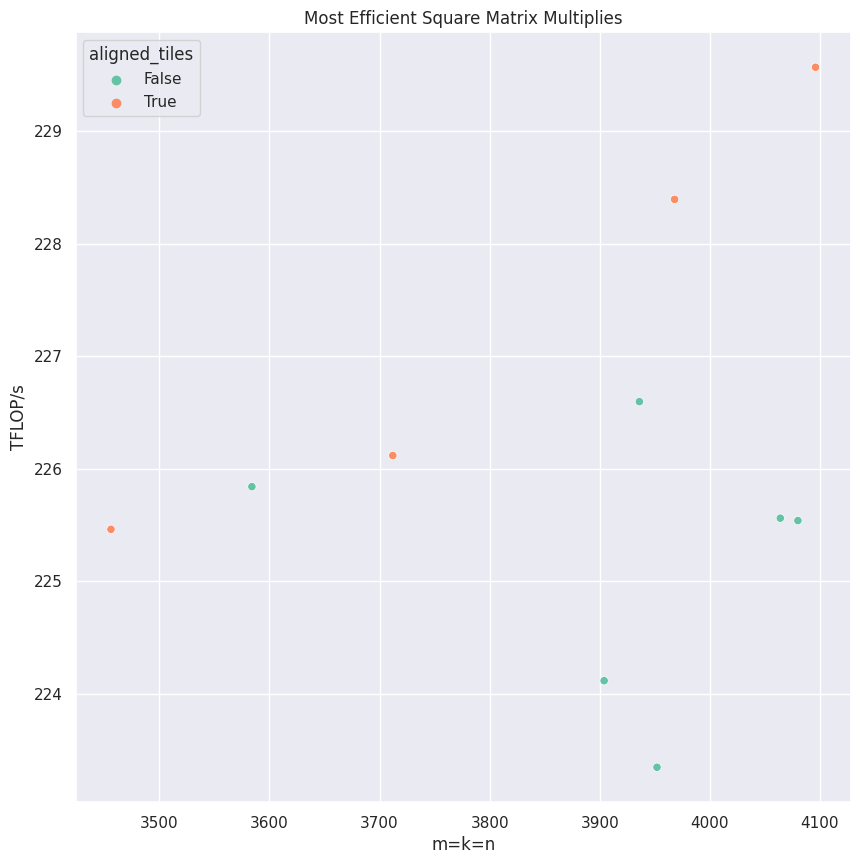

In [26]:
plot = sns.scatterplot(x="m",
                       y="TFLOP/s",
                       data=square_matmul_results_filtered_top_df,
                       hue="aligned_tiles", 
                       palette="Set2",
                      )
plot.set(title=f"Most Efficient Square Matrix Multiplies")
plot.set(xlabel="m=k=n")


As expected, all shapes are divisible by 16 (to make optimal use of tiling and tensor cores), but this does not distinguish the points from one another.

[Text(0.5, 0, 'm=k=n')]

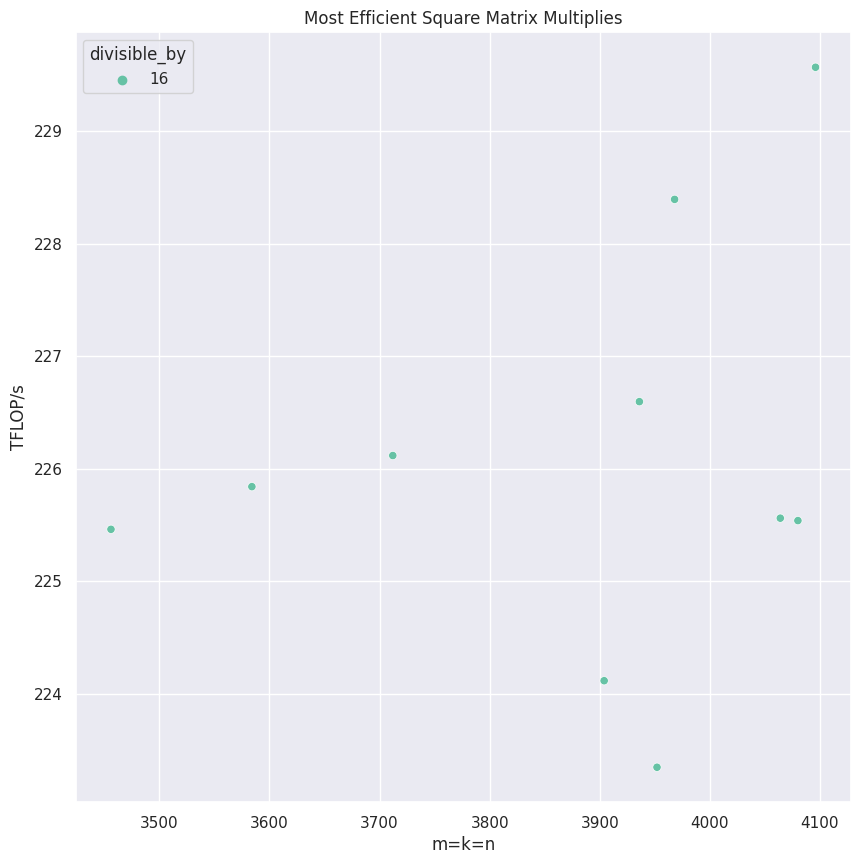

In [27]:
plot = sns.scatterplot(x="m",
                       y="TFLOP/s",
                       data=square_matmul_results_filtered_top_df,
                       hue="divisible_by", 
                       palette="Set2",
                      )
plot.set(title=f"Most Efficient Square Matrix Multiplies")
plot.set(xlabel="m=k=n")


And none have perfectly aligned waves

[Text(0.5, 0, 'm=k=n')]

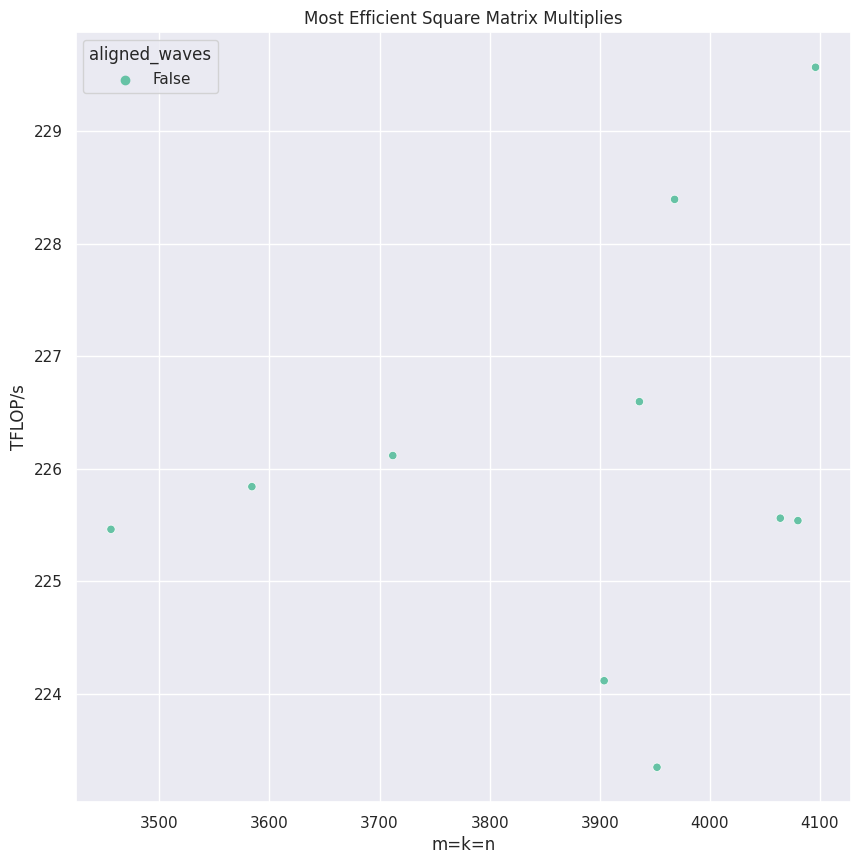

In [28]:
plot = sns.scatterplot(x="m",
                       y="TFLOP/s",
                       data=square_matmul_results_filtered_top_df,
                       hue="aligned_waves", 
                       palette="Set2",
                      )
plot.set(title=f"Most Efficient Square Matrix Multiplies")
plot.set(xlabel="m=k=n")


Though most are pretty close to using a full wave (108)

[Text(0.5, 0, 'm=k=n')]

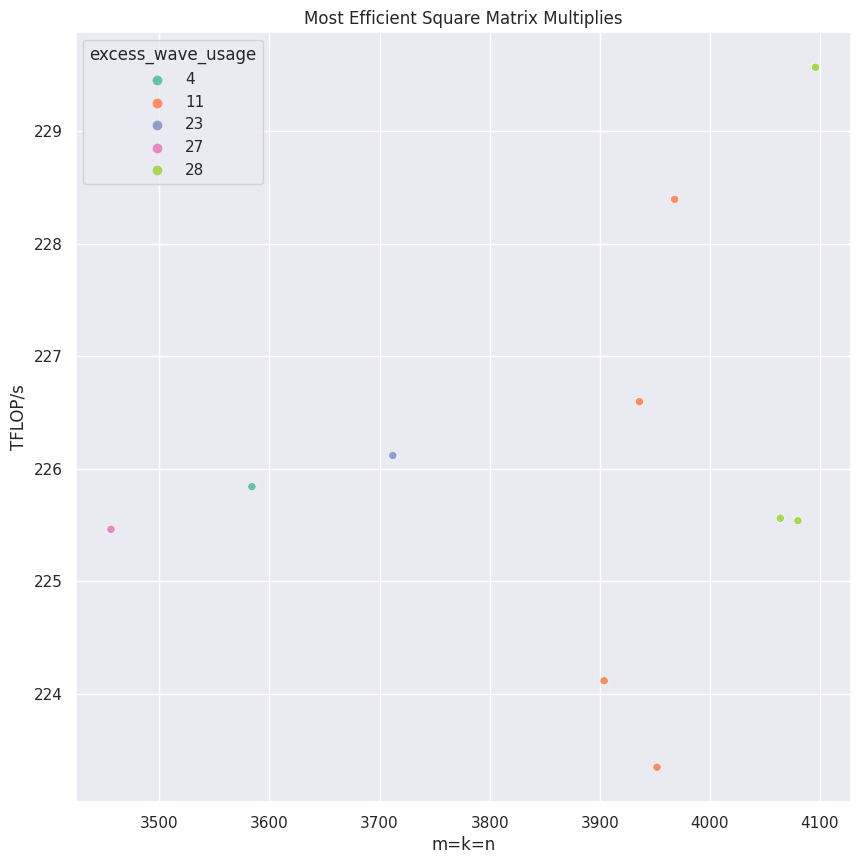

In [29]:
plot = sns.scatterplot(x="m",
                       y="TFLOP/s",
                       data=square_matmul_results_filtered_top_df,
                       hue="excess_wave_usage", 
                       palette="Set2",
                      )
plot.set(title=f"Most Efficient Square Matrix Multiplies")
plot.set(xlabel="m=k=n")


They also run differing kernels:

[Text(0.5, 0, 'm=k=n')]

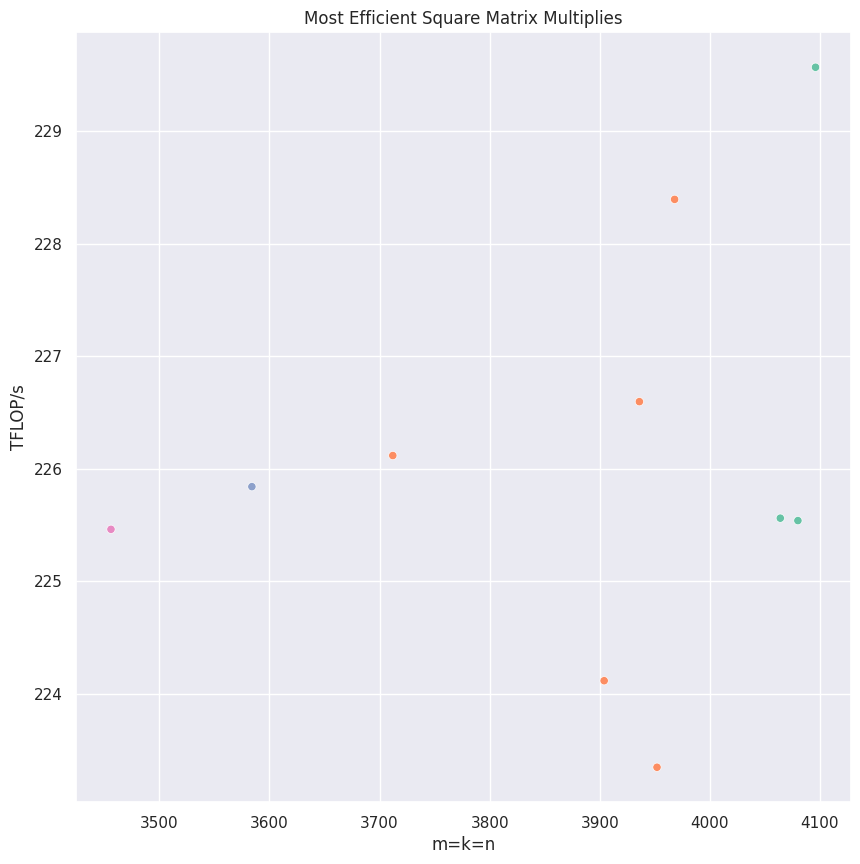

In [30]:
plot = sns.scatterplot(x="m",
                       y="TFLOP/s",
                       data=square_matmul_results_filtered_top_df,
                       hue="kernel", 
                       palette="Set2",
                       legend=False
                      )
plot.set(title=f"Most Efficient Square Matrix Multiplies")
plot.set(xlabel="m=k=n")


Lastly, let us check whether the matrix-sizes align with the 128 byte cache line:

[Text(0.5, 0, 'm=k=n')]

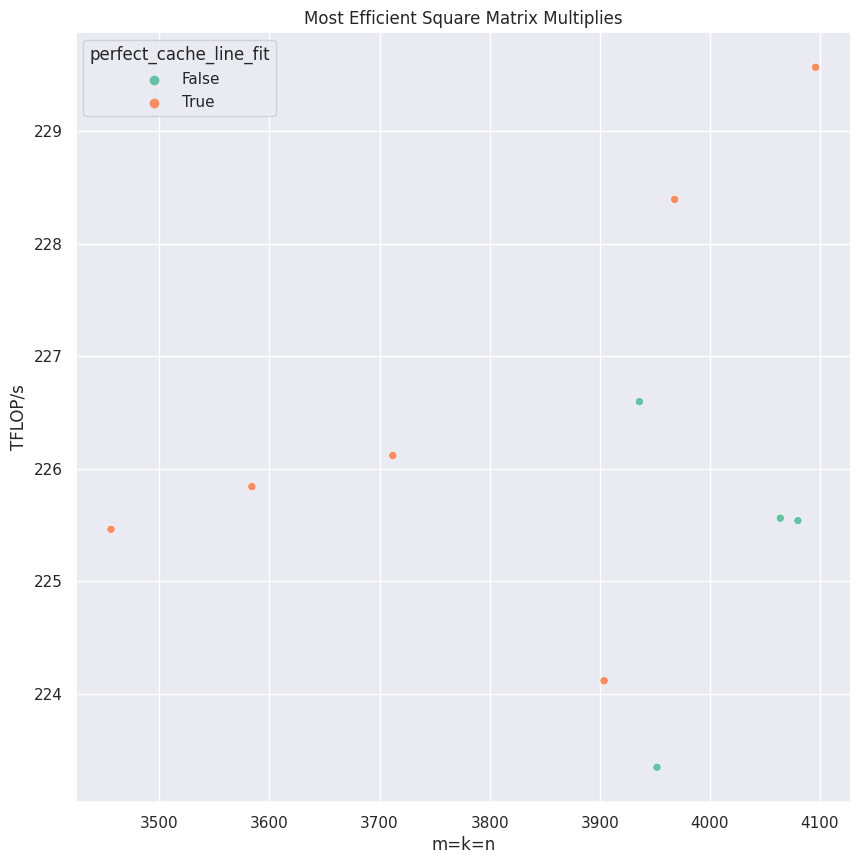

In [31]:

square_matmul_results_filtered_top_df["perfect_cache_line_fit"] = square_matmul_results_filtered_top_df.m * 2 % 128 == 0

plot = sns.scatterplot(x="m",
                       y="TFLOP/s",
                       data=square_matmul_results_filtered_top_df,
                       hue="perfect_cache_line_fit", 
                       palette="Set2",
                      )
plot.set(title=f"Most Efficient Square Matrix Multiplies")
plot.set(xlabel="m=k=n")


All the top-performing points do have perfect cache-line alignment, but some of the lower points do as well. So, I guess a mix of factors are important.

### A Specific Kernel

It is also informative to focus on the plots for a specific kernel, elimnating one source of variation.

Grouping by waves, we see that every wave threshold has a corresponding drop in efficiency:

[Text(0.5, 0, 'm=k=n')]

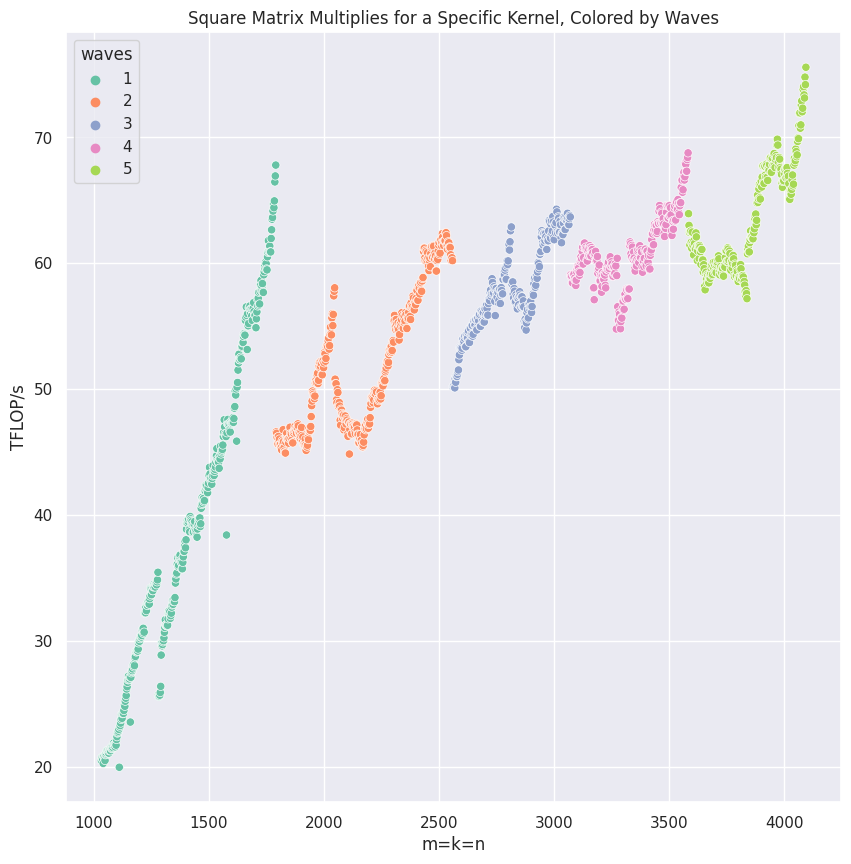

In [32]:

square_matmul_large_drop_mask = (square_matmul_results_filtered_df.kernel == "void cutlass::Kernel<cutlass_75_tensorop_f16_s1688gemm_f16_256x128_nn_align1>(cutlass_75_tensorop_f16_s1688gemm_f16_256x128_nn_align1::Params)")
specific_kernel_square_matmul_results_filtered_df = square_matmul_results_filtered_df[square_matmul_large_drop_mask].copy()
plot = sns.scatterplot(x="m",
                       y="TFLOP/s",
                       data=specific_kernel_square_matmul_results_filtered_df,
                       hue="waves", 
                       palette="Set2",
                      )
plot.set(title=f"Square Matrix Multiplies for a Specific Kernel, Colored by Waves")
plot.set(xlabel="m=k=n")


Every wave threshold also corresponds to a tile-count threshold, but not every drop corresponds to a wave threshold.

Look at tile-count thresholds next. Wave-thresholds only occur at tile-thresholds, so there is some degeneracy here. But, notice that now every large drop in the plot _does_ correspond to the start of some tile-threshold.

[Text(0.5, 0, 'm=k=n')]

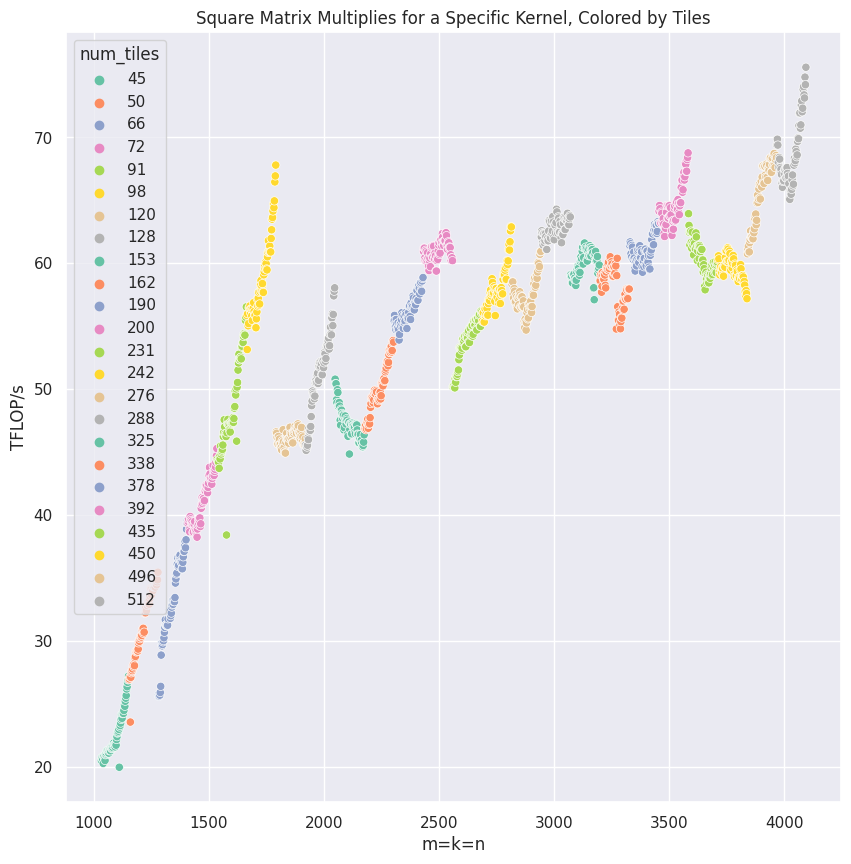

In [33]:
plot = sns.scatterplot(x="m",
                       y="TFLOP/s",
                       data=specific_kernel_square_matmul_results_filtered_df,
                       hue="num_tiles", 
                       palette="Set2",
                      )
plot.set(title=f"Square Matrix Multiplies for a Specific Kernel, Colored by Tiles")
plot.set(xlabel="m=k=n")

The above plots demonstrate the point made in the [NVIDIA docs](https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc): tile and wave quantization are pretty similar, they are primarily differntiated by the scale over which they occur.


Finally, varying inner dimension (and nicely-chosen outer dimensions) shows similar, though smoother, results:

In [34]:
k_scan_results = []
for k in tqdm.tqdm(range(1, 4096 + 1)):
    benchmark(k_scan_results,
              batch_size=1,
              m=4096,
              k=k,
              n=4096)
k_scan_results_df = pd.DataFrame(k_scan_results)


100%|██████████| 4096/4096 [00:47<00:00, 85.34it/s] 


[Text(0.5, 0, 'k')]

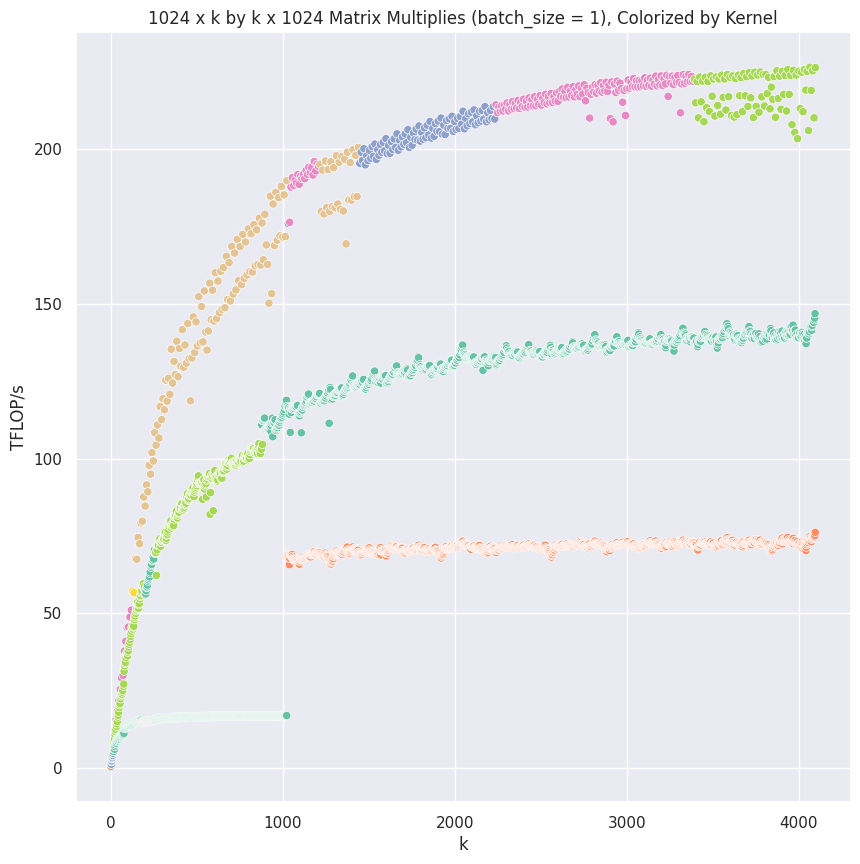

In [35]:
plot = sns.scatterplot(x="k",
                    y="TFLOP/s",
                    data=k_scan_results_df,
                    hue="kernel", 
                    palette="Set2",
                    legend=False
                   )
plot.set(title="1024 x k by k x 1024 Matrix Multiplies (batch_size = 1), Colorized by Kernel")
plot.set(xlabel="k")

Plotting by the divisibility of $k$ (moral: whatever else you do, always be divisible by 16)

[Text(0.5, 0, 'k')]

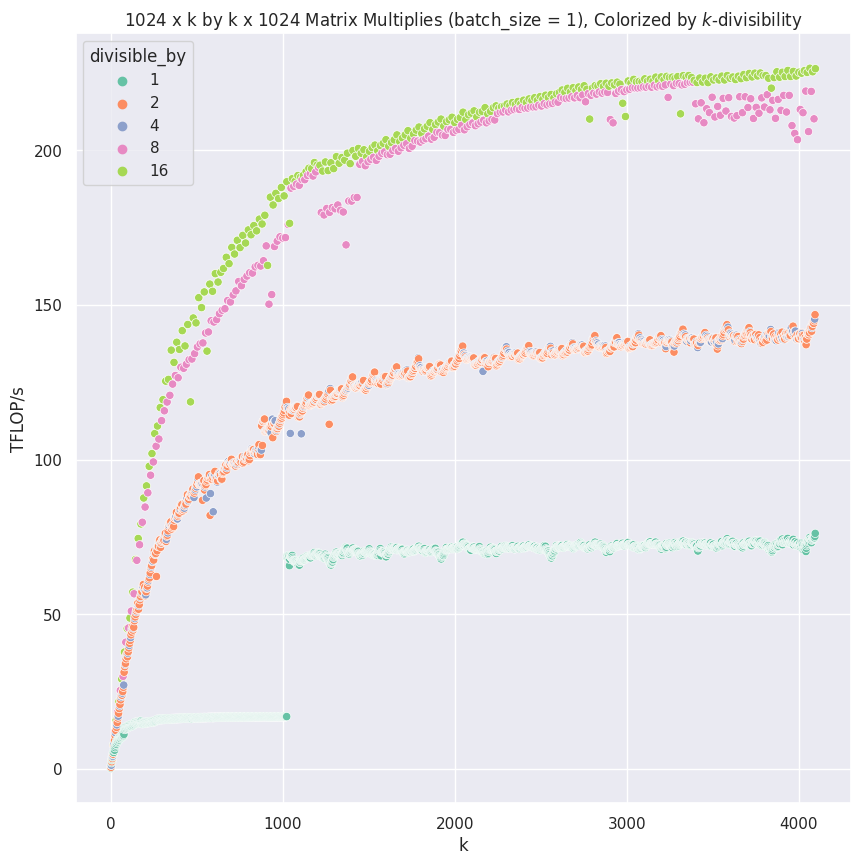

In [36]:

k_scan_results_df["divisible_by"] = k_scan_results_df.apply(code_by_divisibility, axis=1)
plot = sns.scatterplot(x="k",
                    y="TFLOP/s",
                    data=k_scan_results_df,
                    hue="divisible_by", 
                    palette="Set2"
                   )
plot.set(title="1024 x k by k x 1024 Matrix Multiplies (batch_size = 1), Colorized by $k$-divisibility")
plot.set(xlabel="k")

Focusing on the orange grouping, we again see the importance of divisibility even in the same kernel

# Batch Size

Now search over batch size at for fixed, square matrix mutiplies

In [37]:
bsz_results = []
dim = 1024
for batch_size in tqdm.tqdm(range(1, 257)):
    benchmark(bsz_results,
              batch_size=batch_size,
              m=dim,
              k=dim,
              n=dim
             )

100%|██████████| 256/256 [00:04<00:00, 53.18it/s]


In [38]:
bsz_results_df = pd.DataFrame(bsz_results)
bsz_results_df

,time,kernel,batch_size,m,k,n,avg_mem_bandwidth,comp_intensity,TFLOPs,TFLOP/s
0,0.000052,sm80_xmma_gemm_f16f16_f16f32_f32_nn_n_tilesize...,1,1024,1024,1024,1.618073e+11,255.875000,0.001952,37.655301
1,0.000054,sm80_xmma_gemm_f16f16_f16f32_f32_nn_n_tilesize...,2,1024,1024,1024,2.341268e+11,341.166667,0.003904,72.647043
2,0.000054,ampere_fp16_s16816gemm_fp16_256x128_ldg8_f2f_s...,3,1024,1024,1024,3.133070e+11,383.812500,0.005857,109.367791
3,0.000078,ampere_fp16_s16816gemm_fp16_128x128_ldg8_f2f_s...,4,1024,1024,1024,2.686783e+11,409.400000,0.007809,100.041578
4,0.000071,ampere_fp16_s16816gemm_fp16_128x128_ldg8_f2f_s...,5,1024,1024,1024,3.538502e+11,426.458333,0.009761,137.244891
...,...,...,...,...,...,...,...,...,...,...
251,0.002388,ampere_fp16_s16816gemm_fp16_128x128_ldg8_f2f_s...,252,1024,1024,1024,4.443655e+11,509.727273,0.491947,206.005270
252,0.002376,ampere_fp16_s16816gemm_fp16_128x128_ldg8_f2f_s...,253,1024,1024,1024,4.484329e+11,509.735236,0.493899,207.894175
253,0.002411,ampere_fp16_s16816gemm_fp16_128x128_ldg8_f2f_s...,254,1024,1024,1024,4.435930e+11,509.743137,0.495852,205.653583
254,0.002421,ampere_fp16_s16816gemm_fp16_128x128_ldg8_f2f_s...,255,1024,1024,1024,4.434258e+11,509.750977,0.497804,205.579228


They mostly use the same kernel:

[Text(0.5, 1.0, 'Batch Size Efficiency (1024x1024 Multiplies)')]

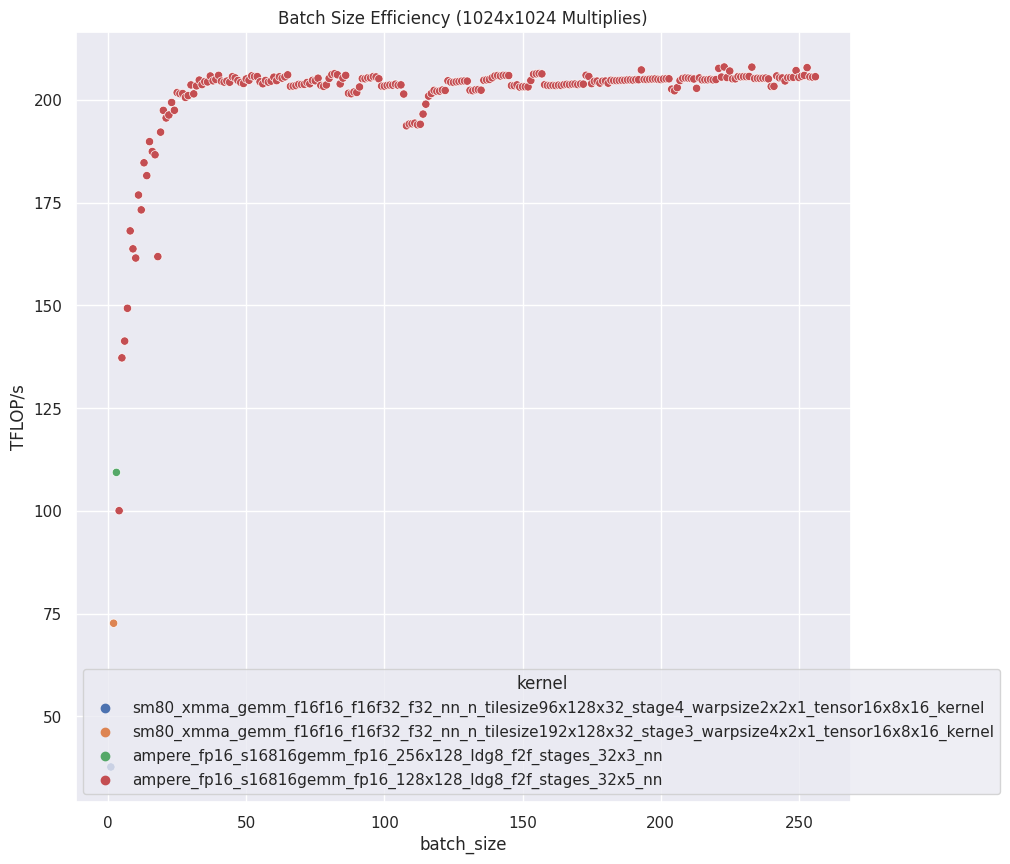

In [39]:
plot = sns.scatterplot(x="batch_size",
                       y="TFLOP/s",
                       data=bsz_results_df,
                       hue="kernel"
                      )
plot.set(title=f"Batch Size Efficiency ({dim}x{dim} Multiplies)")

Try color coding by divisibility of the batch size:

In [40]:
def code_by_divisibility_with_bsz(x, max_exp=3):
    for exp in reversed(range(max_exp + 1)):
        factor = 2 ** exp
        if not x.batch_size % factor:
            return factor

No obvious patterns:

[Text(0.5, 1.0, 'Batch Size Efficiency (1024x1024 Multiplies), Colorized by Batch Size Divisibility')]

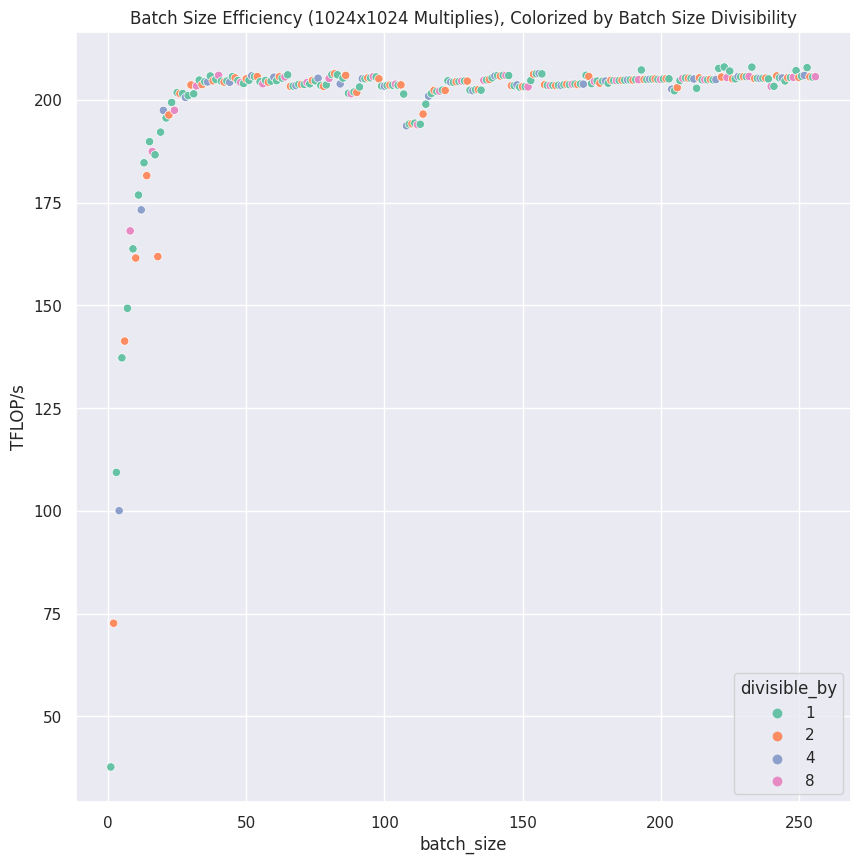

In [41]:

bsz_results_df["divisible_by"] = bsz_results_df.apply(code_by_divisibility_with_bsz, axis=1)

plot = sns.scatterplot(x="batch_size",
                       y="TFLOP/s",
                       data=bsz_results_df,
                       hue="divisible_by", 
                       palette="Set2"
                       )
plot.set(title=f"Batch Size Efficiency ({dim}x{dim} Multiplies), Colorized by Batch Size Divisibility")

In [42]:
def get_tile_tuple(kernel_str):
    """
    Scrapes the kernel name to try and get the tile size
    """
    result = re.search(r"(\d+)x(\d+)", kernel_str)
    if result is None:
        return (None, None)
    tile_x, tile_y = result.groups()[:2]
    return int(tile_x), int(tile_y)

def div_round_up(num, divisor):
    div, mod = divmod(int(num), int(divisor))
    return div + int(bool(mod))

In [43]:

bsz_results_df["tile_x_size"] = bsz_results_df.kernel.apply(lambda x: get_tile_tuple(x)[0])
bsz_results_df["tile_y_size"] = bsz_results_df.kernel.apply(lambda x: get_tile_tuple(x)[1])

bsz_results_df["num_y_tiles"] = bsz_results_df.apply(lambda x: div_round_up(x.m, x.tile_y_size), axis=1)
bsz_results_df["num_x_tiles"] = bsz_results_df.apply(lambda x: div_round_up(x.m, x.tile_x_size), axis=1)
bsz_results_df["num_tiles"] = bsz_results_df.num_x_tiles * bsz_results_df.num_y_tiles * bsz_results_df.batch_size
bsz_results_df["waves"] = bsz_results_df.num_tiles.apply(lambda x: div_round_up(x, 108))
bsz_results_df["aligned_waves"] = bsz_results_df.num_tiles % 108 == 0
bsz_results_df["aligned_tiles"] = (bsz_results_df.m % bsz_results_df.tile_x_size == 0) & (bsz_results_df.m % bsz_results_df.tile_y_size == 0)
bsz_results_df["excess_tile_usage"] = bsz_results_df.m ** 2 % (bsz_results_df.tile_x_size * bsz_results_df.tile_y_size)
bsz_results_df["excess_wave_usage"] = bsz_results_df.num_tiles % 108

                                                      


[Text(0.5, 1.0, 'Batch Size Efficiency (1024x1024 Multiplies), Colorized by Batch Size Divisibility')]

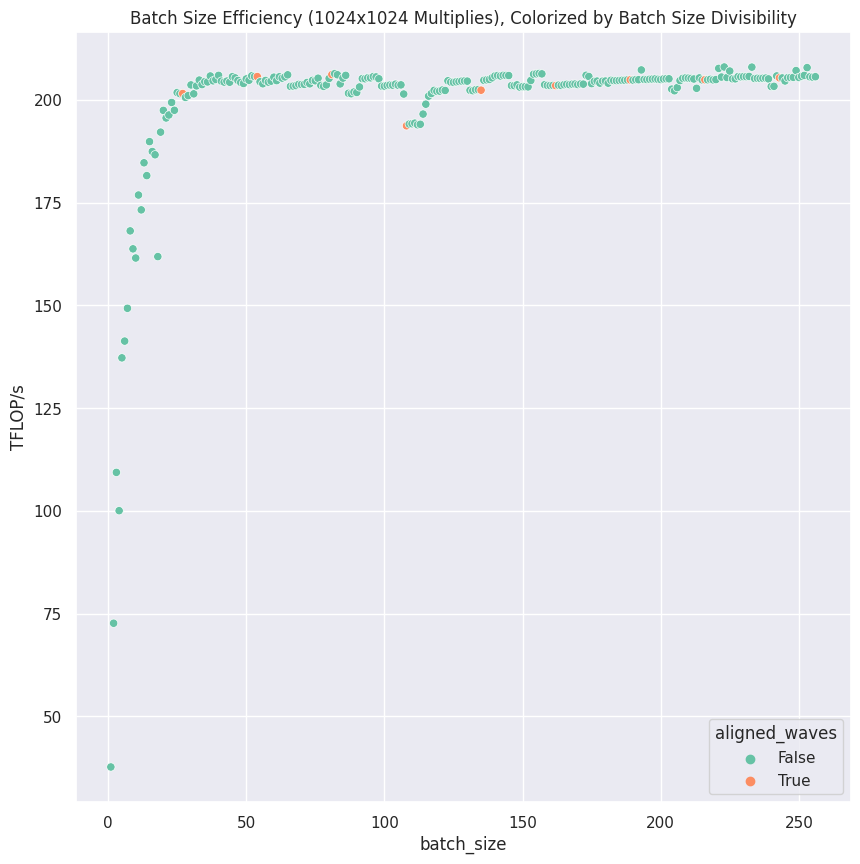

In [44]:
plot = sns.scatterplot(x="batch_size",
                       y="TFLOP/s",
                       data=bsz_results_df,
                       hue="aligned_waves", 
                       palette="Set2"
                       )
plot.set(title=f"Batch Size Efficiency ({dim}x{dim} Multiplies), Colorized by Batch Size Divisibility")

[Text(0.5, 1.0, 'Batch Size Efficiency (1024x1024 Multiplies), Colorized by Batch Size Divisibility')]

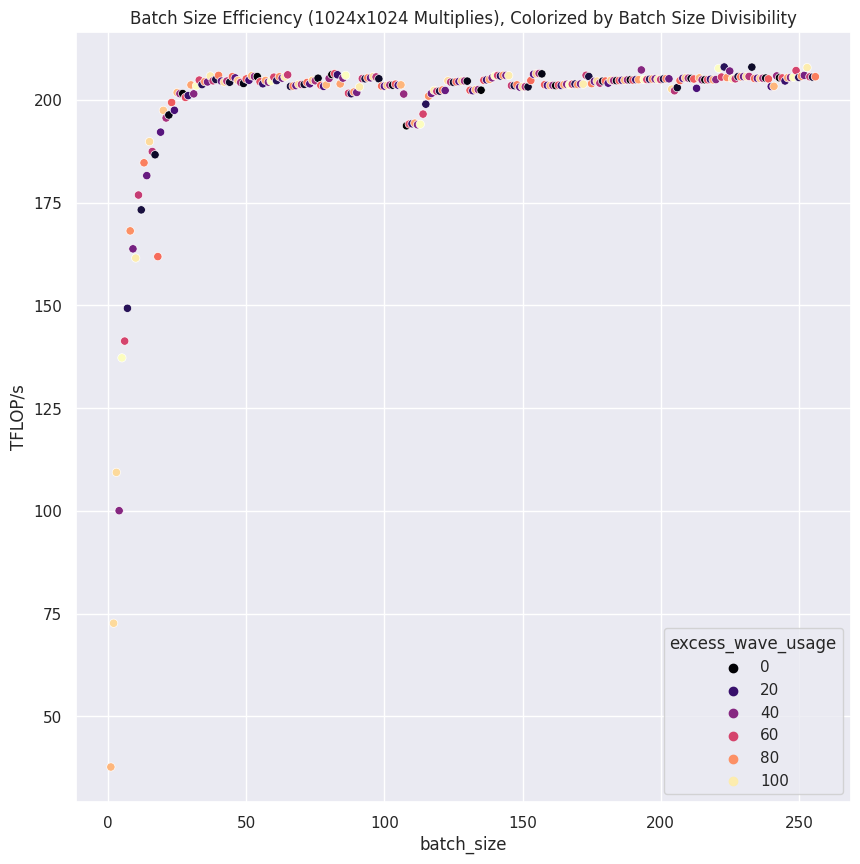

In [45]:
plot = sns.scatterplot(x="batch_size",
                       y="TFLOP/s",
                       data=bsz_results_df,
                       hue="excess_wave_usage", 
                       palette="magma"
                       )
plot.set(title=f"Batch Size Efficiency ({dim}x{dim} Multiplies), Colorized by Batch Size Divisibility")

Zoom in to the first peak. Still not really clear what is up

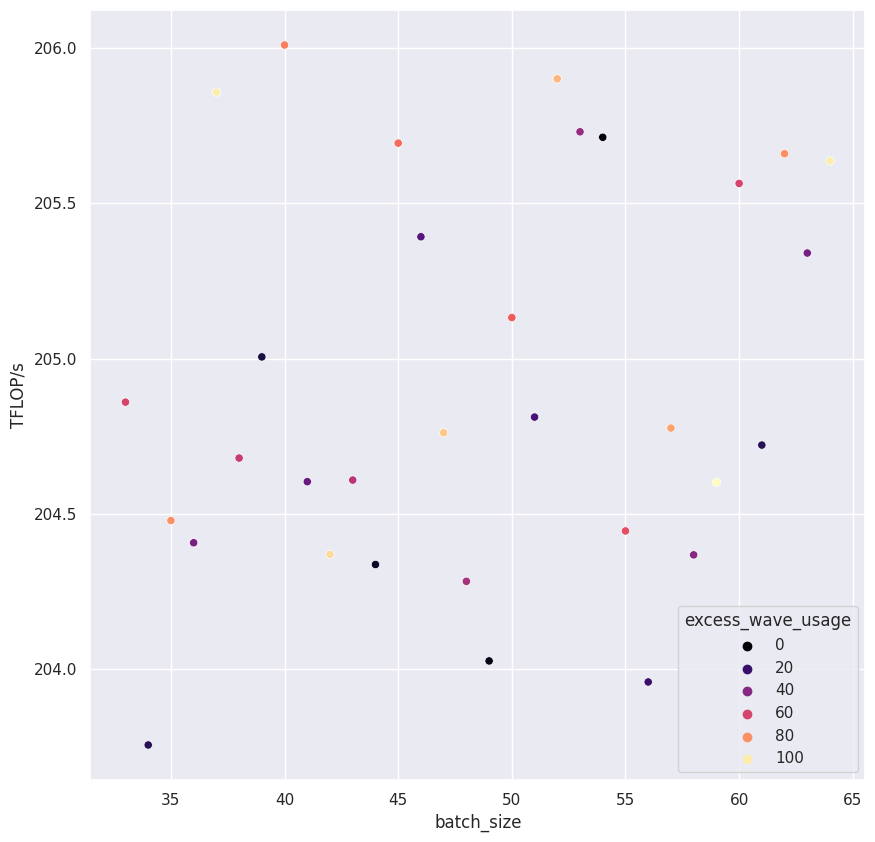

In [46]:

plot = sns.scatterplot(x="batch_size",
                    y="TFLOP/s",
                    data=bsz_results_df[32:64],
                    hue="excess_wave_usage", 
                    palette="magma"
                   )

# Softmax Benchmarking

In [47]:
# There seems to be way more variance for some reason, so increase num_iters

def softmax_benchmark(results, m, warmups=3, num_iters=32):
    assert warmups > 0, "Use at least one warmup"
    with torch.inference_mode():
        T = torch.randn(m, device="cuda", dtype=torch.float16)
        for _ in range(warmups):
            T.softmax(dim=-1)
            
        times_in_sec = []
        for _ in range(num_iters):
            torch.cuda.synchronize()
            start = torch.cuda.Event(enable_timing=True)
            stop = torch.cuda.Event(enable_timing=True)
            start.record()
            T.softmax(dim=-1)
            stop.record()
            torch.cuda.synchronize()

            # CUDA timings are in ms:
            times_in_sec.append(start.elapsed_time(stop) / 1e3)
        time = sum(times_in_sec) / len(times_in_sec)
        mem_in_bytes = T.element_size() * T.numel()
        del T
        results.append({"time": time,
                        "m": m,
                        "avg_mem_bandwidth": 2 * mem_in_bytes / time})
        


In [48]:
softmax_results = []
for m in tqdm.tqdm(range(1, 2 ** 16 + 1)):
    softmax_benchmark(softmax_results, m)
softmax_results_df = pd.DataFrame(softmax_results)

100%|██████████| 65536/65536 [02:21<00:00, 463.63it/s]


[Text(0.5, 1.0, 'Softmax Timing')]

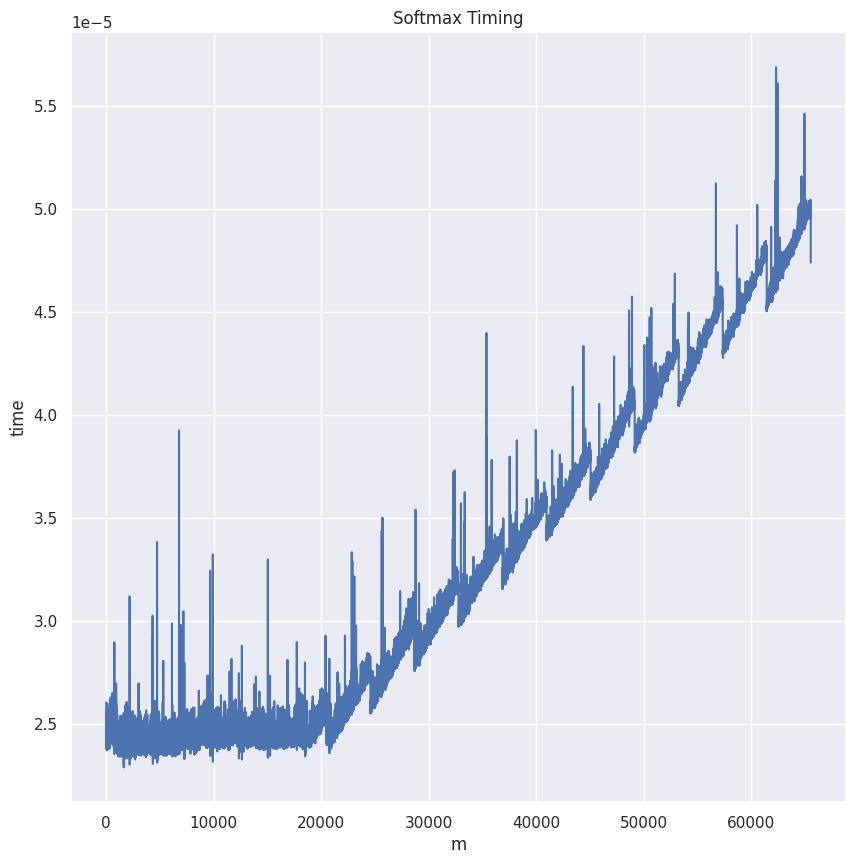

In [49]:
plot = sns.lineplot(x="m",
                    y="time",
                    data=softmax_results_df
                   )
plot.set(title="Softmax Timing")


So it seems latency dominated until about ~15k, and then some linear trend upwards with drops at particularly bad shapes for loading data/kernel sizes/waves? TBD.